In [3]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import cftime
import numpy as np
import matplotlib.dates as mdates

In [4]:
df_cfc11 = pd.read_csv("../data/input/f11_gblannualdata", skiprows=1, sep=r'\s+', names=["year", "CFC11"]).set_index("year")
df_cfc12 = pd.read_csv("../data/input/f12_gblannualdata", skiprows=1, sep=r'\s+', names=["year", "CFC12"]).set_index("year")
df_sf6 = pd.read_csv("../data/input/sf6_monthly_cmip6_from_esgf.csv", skiprows=1, names=["time", "SF6"])
df_sf6['year'] = [np.int64(t[:4]) for t in df_sf6['time']]
df_sf6 = df_sf6.groupby('year').mean(numeric_only=True)

In [5]:
bc = xr.open_dataset("/archive/oar.gfdl.cmip6/datasets/OMIP/cfc/CFC_histories_revised_2015_20x20deg.20171208.nc", decode_times=False) # file for the historical run
bc_new = bc.copy()
bc_new['Time'] = bc_new['Time'] + 1601. # convert to CE years for convenient referencing and temporal interpolation keep_attrs=True)
bc_new = bc_new.interp(Time = np.append(bc_new['Time'].values[:-2], np.arange(2015.5, 2300., 1.)))

for i, t in enumerate(bc_new['Time']):
    if t>2015:
        # Remove global mean (but leave behind hemispheric spatial pattern) and add in global mean from SSP5-8.5 protocol
        bc_new['CFC11'][i,:,:] += -bc_new['CFC11'].sel(Time=t.values).mean() + df_cfc11['CFC11'].loc[df_cfc11.index==t.values].values[0]
        bc_new['CFC12'][i,:,:] += -bc_new['CFC12'].sel(Time=t.values).mean() + df_cfc12['CFC12'].loc[df_cfc12.index==t.values].values[0]
        bc_new['SF6'][i,:,:] += -bc_new['SF6'].sel(Time=t.values).mean() + df_sf6['SF6'].loc[df_sf6.index==np.int64(np.floor(t.values))].values[0]

bc_new['Time'] = bc_new['Time'] - 1601. # convert back to years since 1601
bc_new['Time'].attrs = bc['Time'].attrs

encoding = {v: {"_FillValue": 1e+20} for v in list(bc_new.data_vars) + list(bc_new.coords)}
bc_new.to_netcdf("/archive/hfd/datasets/input_files/CFC_SSP585_20x20deg.20220203.nc", mode="w", encoding=encoding)

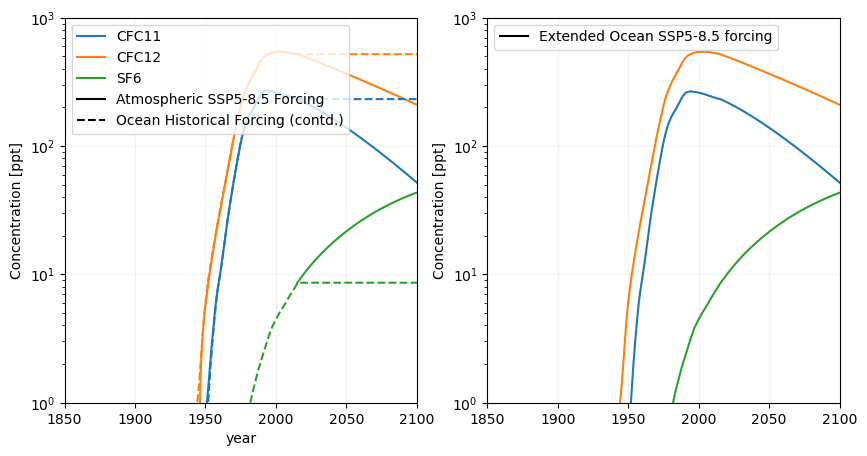

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
df_cfc11['CFC11'].plot(color="C0")
df_cfc12['CFC12'].plot(color="C1")
df_sf6['SF6'].plot(color="C2")
plt.plot(bc['Time']+1601., bc['CFC11'].mean(['Longitude', 'Latitude']), ls="--")
plt.plot(bc['Time']+1601., bc['CFC12'].mean(['Longitude', 'Latitude']), ls="--")
plt.plot(bc['Time']+1601., bc['SF6'].mean(['Longitude', 'Latitude']), ls="--")
plt.plot([], [], "k-", label="Atmospheric SSP5-8.5 Forcing")
plt.plot([], [], "k--", label="Ocean Historical Forcing (contd.)")
plt.grid(True, alpha=0.15)
plt.ylim([1, 1000])
plt.legend(loc="upper left")
plt.ylabel("Concentration [ppt]")
plt.yscale("log")
plt.xlim(1850, 2100)

plt.subplot(1,2,2)
plt.plot(bc_new['Time']+1601., bc_new['CFC11'].mean(['Longitude', 'Latitude']), ls="-")
plt.plot(bc_new['Time']+1601., bc_new['CFC12'].mean(['Longitude', 'Latitude']), ls="-")
plt.plot(bc_new['Time']+1601., bc_new['SF6'].mean(['Longitude', 'Latitude']), ls="-")
plt.plot([], [], "k-", label="Extended Ocean SSP5-8.5 forcing")
plt.grid(True, alpha=0.15)
plt.ylim([1, 1000])
plt.legend(loc="upper left")
plt.ylabel("Concentration [ppt]")
plt.yscale("log")
plt.xlim(1850, 2100)
plt.savefig("../figures/extended_transient_tracer_BCs.png", bbox_inches="tight", dpi=100)

In [7]:
bc_new.close()